In [97]:
import pandas as pd
import talib as ta
import datetime as dt
import math 
import numpy as np
import plotly.graph_objects as go
from math import floor

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from numpy.linalg import eig
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, mean_squared_error, r2_score,mean_absolute_error,precision_score,recall_score, f1_score


from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model

In [2]:
import yfinance as yf

In [3]:
ticker = yf.Ticker('BTC-USD')

df = ticker.history(start="2017-01-02", end="2022-02-28")

In [4]:
df.reset_index(inplace=True)

In [5]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0,0
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0,0
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0,0
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0,0
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0,0
...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,0,0
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,0,0
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,0,0
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,0,0


In [6]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

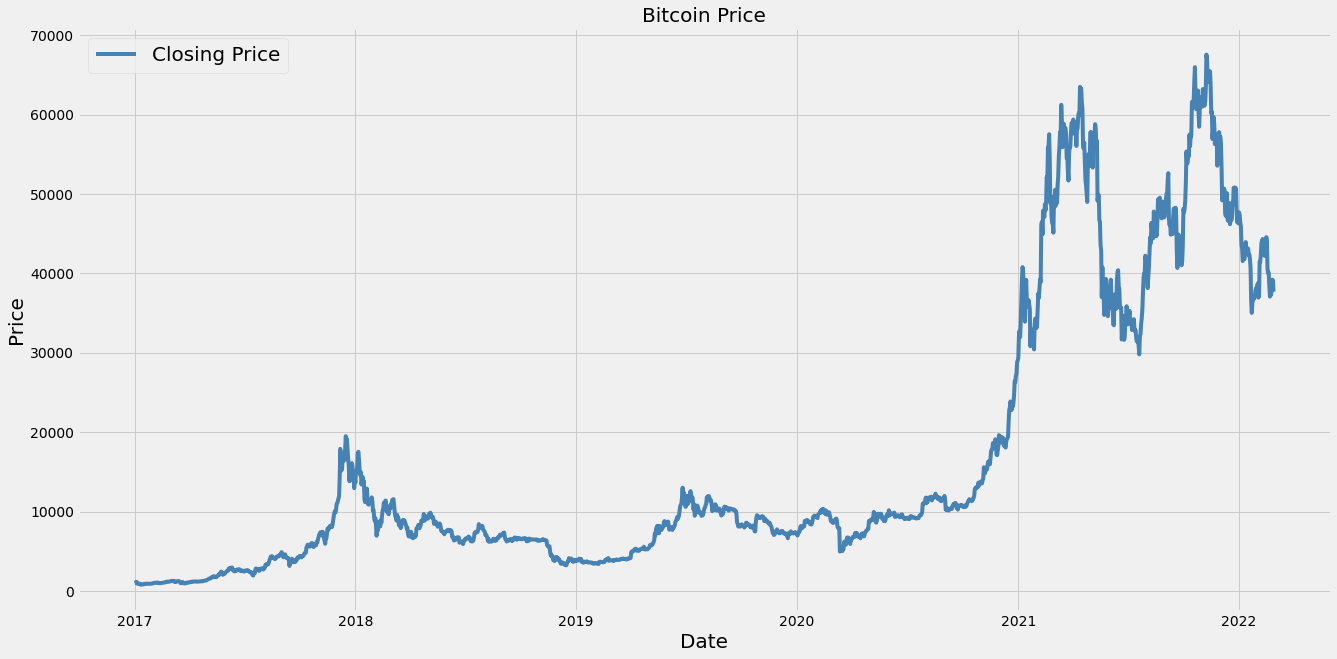

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label='Closing Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price', fontsize = 20)
ax.legend(loc='upper left',prop={'size': 20})

In [8]:
df.drop(['Dividends', 'Stock Splits'], axis = 1, inplace= True)

In [9]:
# Moving Average
df['MA_50'] = ta.MA(df['Close'].values, timeperiod=50)
df['MA_200'] = ta.MA(df['Close'].values, timeperiod=200)

# Simple Moving Average
df['SMA_50'] = ta.SMA(df['Close'].values, timeperiod=50)
df['SMA_200'] = ta.SMA(df['Close'].values, timeperiod=200)

# Exponential moving average
df['EMA_50'] = ta.EMA(df['Close'].values, timeperiod=50)
df['EMA_100'] = ta.EMA(df['Close'].values, timeperiod=100)

# Moving average convergence divergence (MACD)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod= 9)

# Relative Strength index (RSI)
# df['rsi_5'] = ta.RSI(df['Close'].values, timeperiod=5)
df['rsi_14'] = ta.RSI(df['Close'].values, timeperiod=14)

#Bollinger Band (BB)
df['BB_Upper'], df['BB_middle'], df['BB_lower'] = ta.BBANDS(df['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# df['return'] = np.log(df['Close']/df['Close'].shift(1))

In [10]:
df.fillna(0, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1884 non-null   datetime64[ns]
 1   Open        1884 non-null   float64       
 2   High        1884 non-null   float64       
 3   Low         1884 non-null   float64       
 4   Close       1884 non-null   float64       
 5   Volume      1884 non-null   int64         
 6   MA_50       1884 non-null   float64       
 7   MA_200      1884 non-null   float64       
 8   SMA_50      1884 non-null   float64       
 9   SMA_200     1884 non-null   float64       
 10  EMA_50      1884 non-null   float64       
 11  EMA_100     1884 non-null   float64       
 12  macd        1884 non-null   float64       
 13  macdsignal  1884 non-null   float64       
 14  macdhist    1884 non-null   float64       
 15  rsi_14      1884 non-null   float64       
 16  BB_Upper    1884 non-nul

In [12]:
df

,Date,Open,High,Low,Close,Volume,MA_50,MA_200,SMA_50,SMA_200,EMA_50,EMA_100,macd,macdsignal,macdhist,rsi_14,BB_Upper,BB_middle,BB_lower
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,40619.632969,49346.491367,40619.632969,49346.491367,41873.910860,44666.004424,-772.392026,-178.537677,-593.854350,37.529047,46152.580286,41548.570898,36944.561511
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,40514.905078,49319.163828,40514.905078,49319.163828,41735.036292,44540.590660,-828.791941,-308.588529,-520.203411,42.098947,46203.114098,41390.157617,36577.201136
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,40435.970859,49283.407910,40435.970859,49283.407910,41636.180702,44435.117949,-793.207172,-405.512258,-387.694914,45.736592,46184.050294,41278.810352,36373.570409
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,40386.915781,49251.008496,40386.915781,49251.008496,41536.924535,44329.573999,-764.988735,-477.407553,-287.581182,45.356934,46077.309351,41113.446094,36149.582836


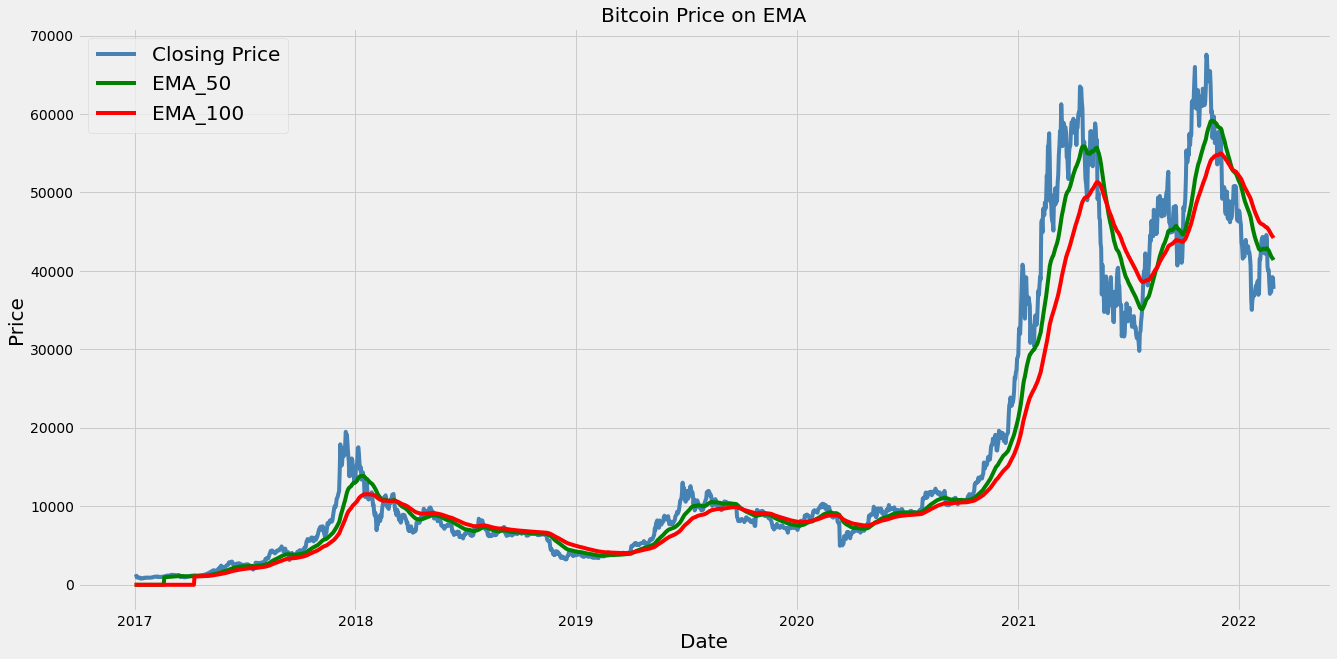

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label='Closing Price')
ax.plot(df['Date'],df['EMA_50'], color='g',label='EMA_50')
ax.plot(df['Date'],df['EMA_100'], color='r', label='EMA_100')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price on EMA', fontsize = 20)
ax.legend(loc='upper left',prop={'size': 20})

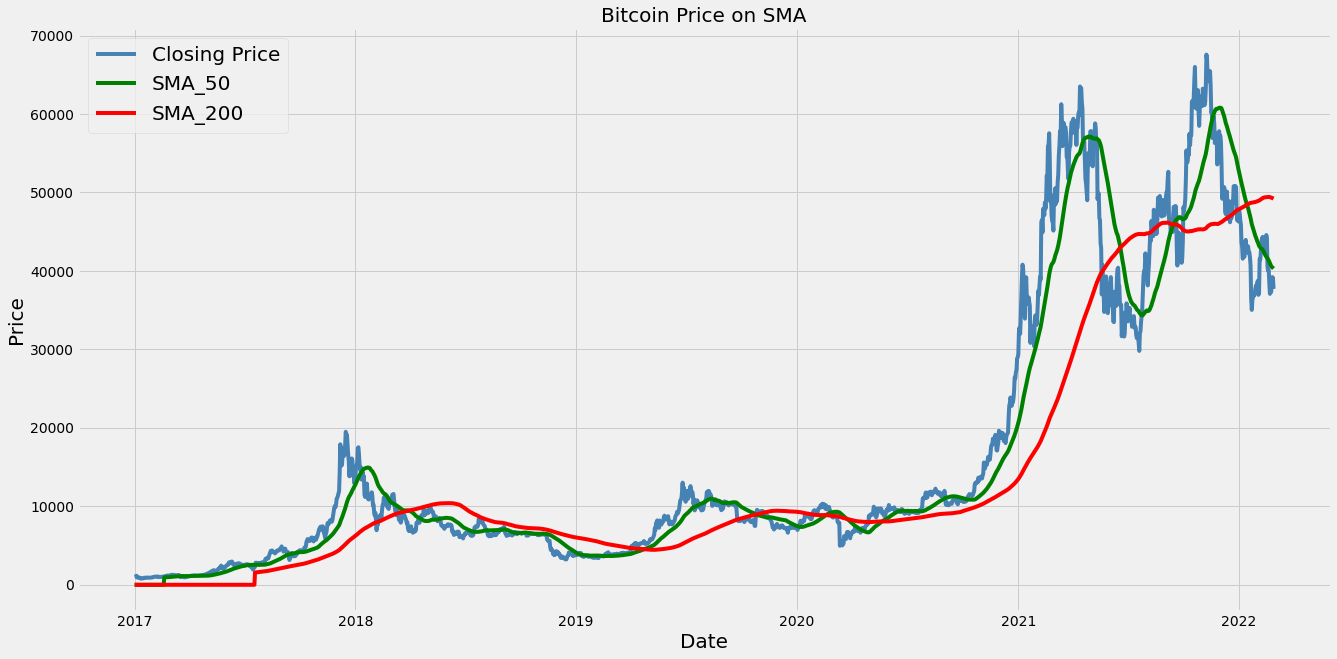

In [104]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label='Closing Price')
ax.plot(df['Date'],df['SMA_50'], color='g',label='SMA_50')
ax.plot(df['Date'],df['SMA_200'], color='r', label='SMA_200')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price on SMA', fontsize = 20)
ax.legend(loc='upper left',prop={'size': 20})

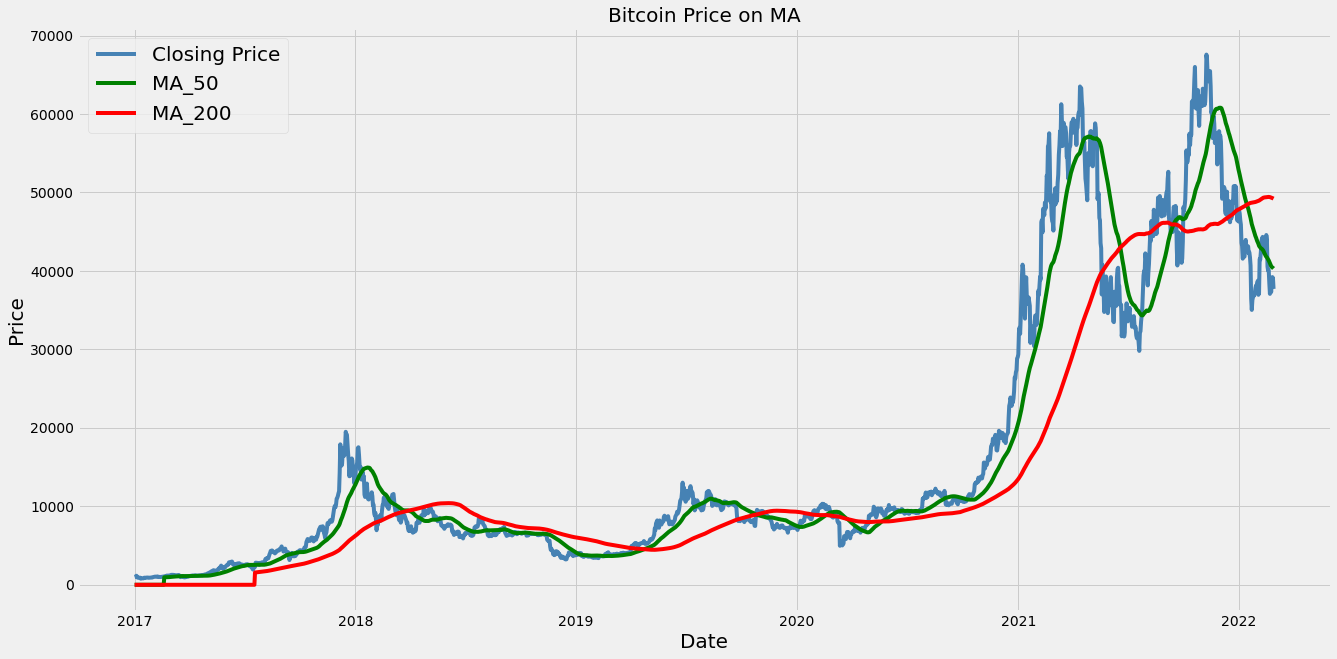

In [105]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label='Closing Price')
ax.plot(df['Date'],df['MA_50'], color='g',label='MA_50')
ax.plot(df['Date'],df['MA_200'], color='r', label='MA_200')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price on MA', fontsize = 20)
ax.legend(loc='upper left',prop={'size': 20})

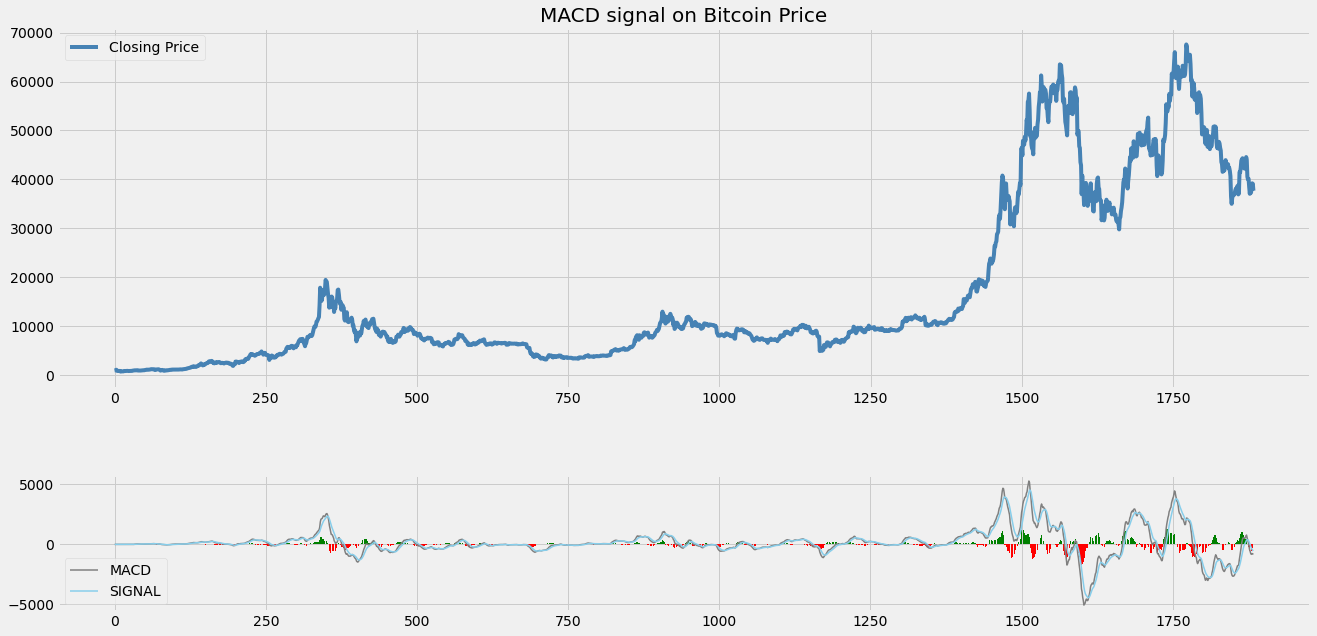

In [16]:
prices = df['Close']
macd = df['macd']
signal = df['macdsignal']
hist = df['macdhist']



def plot_macd(prices, macd, signal, hist):
     
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (6,0), rowspan = 3, colspan = 1)

    ax1.plot(prices, color = 'steelblue', label = 'Closing Price')
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = 'r') ##ef5350
        else:
            ax2.bar(prices.index[i], hist[i], color = 'g') ##26a69a

    ax1.legend(loc = 'upper left')
    ax1.set_title('MACD signal on Bitcoin Price', fontsize = 20)
    ax2.legend(loc = 'lower left')

plot_macd(df['Close'], df['macd'], df['macdsignal'], df['macdhist'])

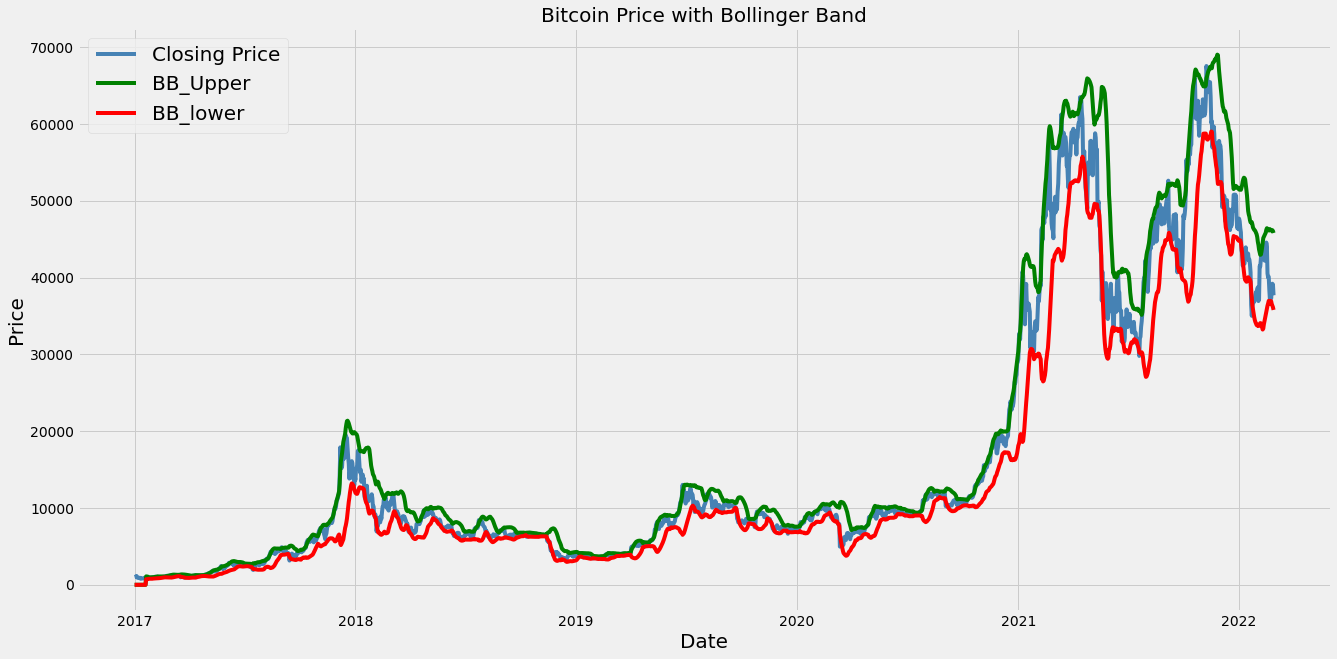

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label='Closing Price')
ax.plot(df['Date'],df['BB_Upper'], color='g',label='BB_Upper')
ax.plot(df['Date'],df['BB_lower'], color='r', label='BB_lower')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price with Bollinger Band', fontsize = 20)
ax.legend(loc='upper left',prop={'size': 20})

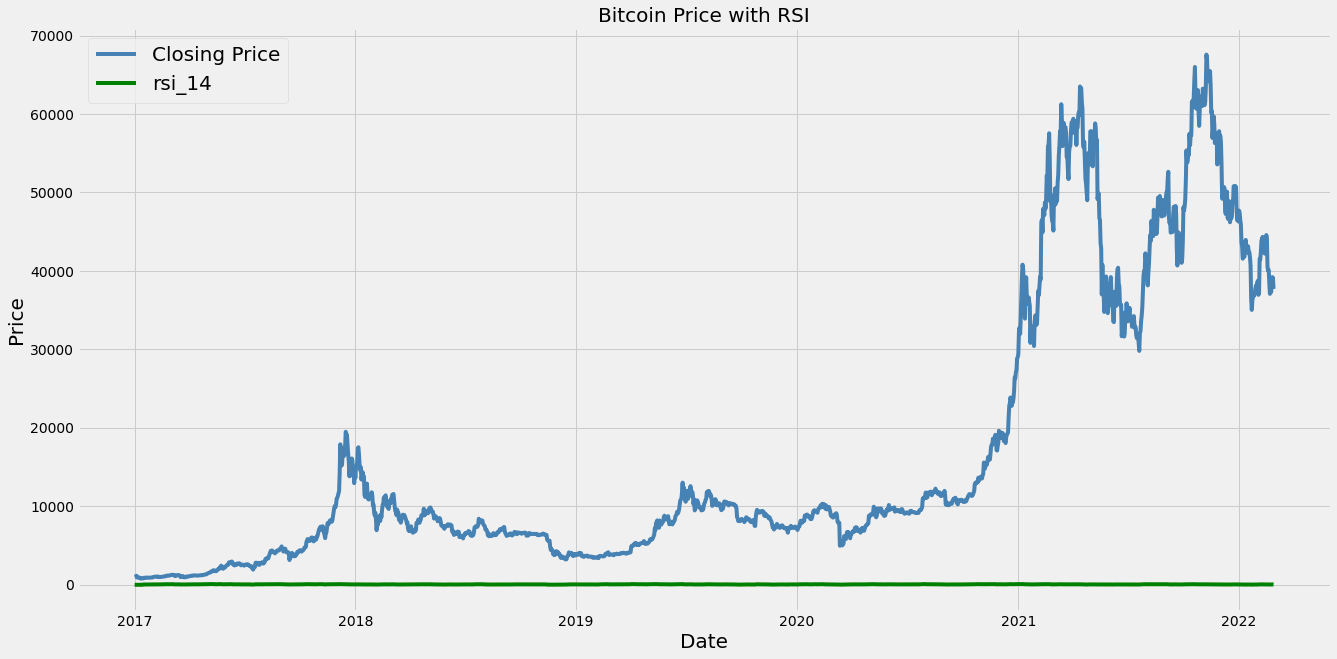

In [18]:
# RSI 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label='Closing Price')
ax.plot(df['Date'],df['rsi_14'], color='g',label='rsi_14')
# ax.plot(df['Date'],df['MA_200'], color='r', label='MA_100')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price with RSI', fontsize = 20)
ax.legend(loc='upper left',prop={'size': 20})

# Feature selection and Train test split

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1884 non-null   datetime64[ns]
 1   Open        1884 non-null   float64       
 2   High        1884 non-null   float64       
 3   Low         1884 non-null   float64       
 4   Close       1884 non-null   float64       
 5   Volume      1884 non-null   int64         
 6   MA_50       1884 non-null   float64       
 7   MA_200      1884 non-null   float64       
 8   SMA_50      1884 non-null   float64       
 9   SMA_200     1884 non-null   float64       
 10  EMA_50      1884 non-null   float64       
 11  EMA_100     1884 non-null   float64       
 12  macd        1884 non-null   float64       
 13  macdsignal  1884 non-null   float64       
 14  macdhist    1884 non-null   float64       
 15  rsi_14      1884 non-null   float64       
 16  BB_Upper    1884 non-nul

In [20]:
X = df[['Open','High','Low','Volume','MA_50','MA_200','SMA_50','SMA_200','EMA_50','EMA_100','macd','macdsignal','macdhist','rsi_14','BB_Upper','BB_middle','BB_lower']]
y = df['Close']
#y = df.iloc[:, [4]].values

In [21]:
y.shape

(1884,)

In [22]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
#scaled_y = scaler.fit_transform(y)

In [23]:
training_days = pd.date_range(start="2017-01-02",end="2021-12-31")
num_training_days = len(training_days)
num_training_days

1825

In [24]:
X_train = scaled_X[:num_training_days]
y_train = y[:num_training_days]

X_test = scaled_X[num_training_days:]
y_test = y[num_training_days:]


In [25]:
train = df[:num_training_days]
test = df[num_training_days:]

In [26]:
X_train.shape

(1825, 17)

In [27]:
X_test.shape

(59, 17)

In [28]:
y_test.shape

(59,)

In [29]:
train

,Date,Open,High,Low,Close,Volume,MA_50,MA_200,SMA_50,SMA_200,EMA_50,EMA_100,macd,macdsignal,macdhist,rsi_14,BB_Upper,BB_middle,BB_lower
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,20964372926,54726.787031,47575.411406,54726.787031,47575.411406,52459.630363,52673.774885,-1036.559746,-1828.605036,792.045291,50.772612,51954.127515,48627.143164,45300.158813
1821,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,24324345758,54473.055625,47645.100508,54473.055625,47645.100508,52388.288700,52633.510392,-864.435586,-1635.771146,771.335561,50.175469,51943.802217,48624.159766,45304.517314
1822,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,33430376883,54073.496172,47696.372793,54073.496172,47696.372793,52200.075632,52533.616235,-963.158844,-1501.248686,538.089842,40.840563,51709.772709,48478.362695,45246.952682
1823,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,30049226299,53662.953828,47750.833770,53662.953828,47750.833770,51974.375056,52413.043853,-1120.800746,-1425.159098,304.358352,37.986943,51752.271502,48416.992188,45081.712873


# Linear Regression Model 

In [30]:
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred = LR.predict(X_test)
lr_r2 = r2_score(y_test, y_pred)
lr_r2


0.9675595033100597

In [32]:
lr_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
lr_rmse
# RMSE value is too high

557.7688298900013

In [33]:
lr_mae = mean_absolute_error(y_test, y_pred)
lr_mae

430.0784755196016

In [34]:
lr_mape = mean_absolute_percentage_error(y_test, y_pred)
lr_mape

0.010697847627013547

C:\Users\user\AppData\Local\Temp/ipykernel_6556/3606808883.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_test['Predictions'] = 0
C:\Users\user\AppData\Local\Temp/ipykernel_6556/3606808883.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_test['Predictions'] = y_pred


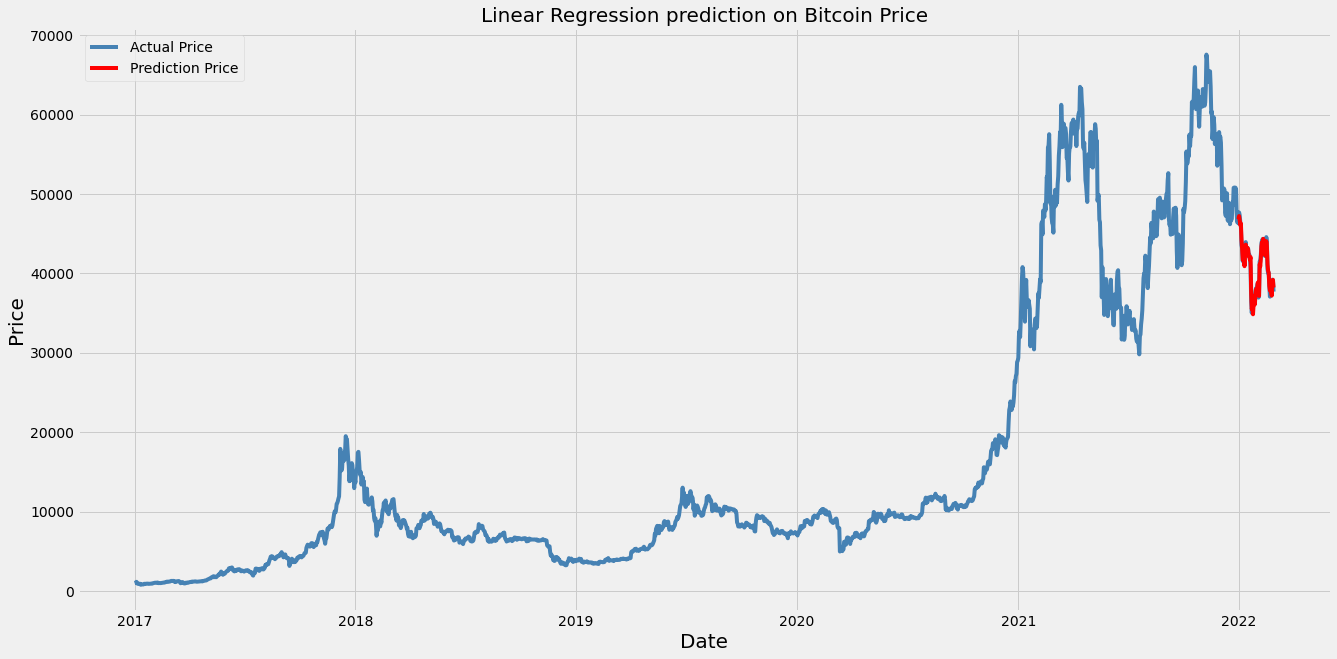

In [39]:
#plot
lr_train = df[:num_training_days]
lr_test = df[num_training_days:]

lr_test['Predictions'] = 0
lr_test['Predictions'] = y_pred

lr_test.index = df[num_training_days:].index
# lr_train.index = df[:num_training_days].index

# Plotting of graph 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label = 'Actual Price')
ax.plot(lr_test['Date'],lr_test['Predictions'], color = 'r', label = 'Prediction Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Linear Regression prediction on Bitcoin Price', fontsize = 20)
ax.legend()


# XGBoost Regressor 

In [36]:
XGB = XGBRegressor()
XGB.fit(X_train, y_train)
y_pred_xgb = XGB.predict(X_test)


In [44]:
#MAE
xgb_mae = mean_absolute_error(y_test,y_pred_xgb)
xgb_mae

1194.4315413135594

In [45]:
xgb_rmse = math.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_rmse

1391.9210642861324

In [46]:
xgb_mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
xgb_mape

0.02916291512827374

C:\Users\user\AppData\Local\Temp/ipykernel_6556/2079074672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg_test['Predictions'] = 0
C:\Users\user\AppData\Local\Temp/ipykernel_6556/2079074672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg_test['Predictions'] = y_pred_xgb


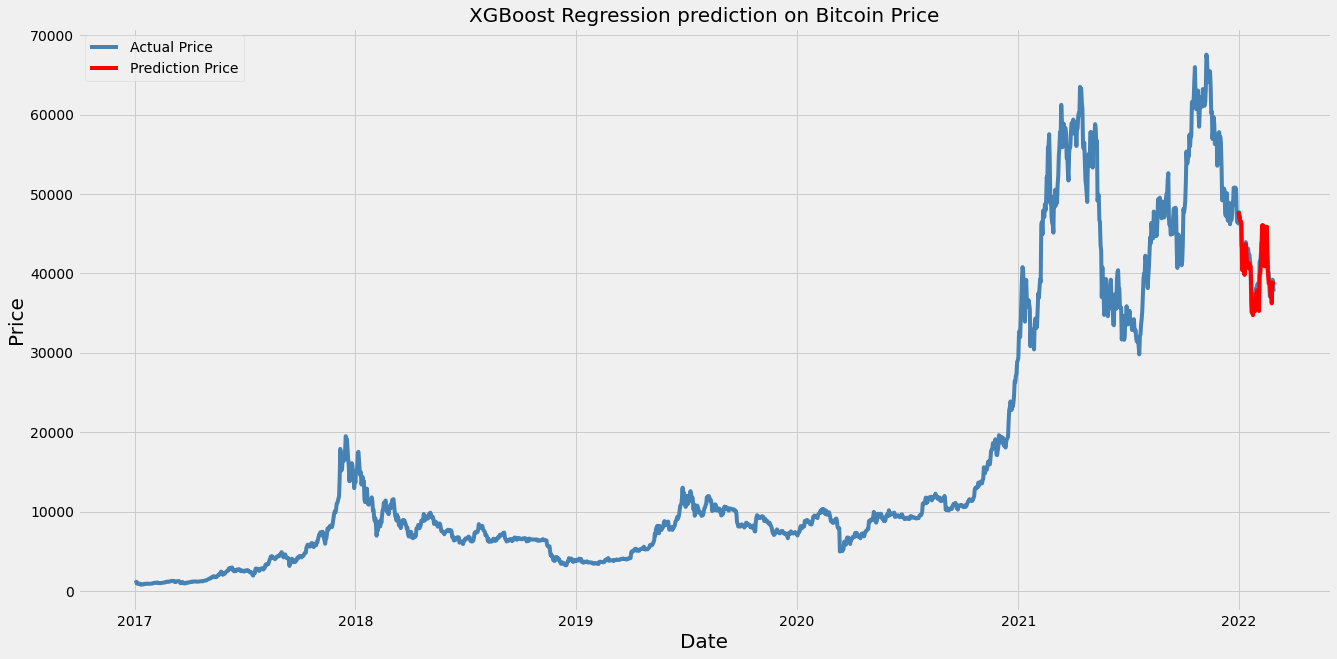

In [47]:
#plot
xg_train = df[:num_training_days]
xg_test = df[num_training_days:]

xg_test['Predictions'] = 0
xg_test['Predictions'] = y_pred_xgb

xg_test.index = df[num_training_days:].index
# lr_train.index = df[:num_training_days].index

# Plotting of graph 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label = 'Actual Price')
ax.plot(xg_test['Date'],xg_test['Predictions'], color = 'r', label = 'Prediction Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('XGBoost Regression prediction on Bitcoin Price', fontsize = 20)
ax.legend()


In [43]:
df

,Date,Open,High,Low,Close,Volume,MA_50,MA_200,SMA_50,SMA_200,EMA_50,EMA_100,macd,macdsignal,macdhist,rsi_14,BB_Upper,BB_middle,BB_lower
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,40619.632969,49346.491367,40619.632969,49346.491367,41873.910860,44666.004424,-772.392026,-178.537677,-593.854350,37.529047,46152.580286,41548.570898,36944.561511
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,40514.905078,49319.163828,40514.905078,49319.163828,41735.036292,44540.590660,-828.791941,-308.588529,-520.203411,42.098947,46203.114098,41390.157617,36577.201136
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,40435.970859,49283.407910,40435.970859,49283.407910,41636.180702,44435.117949,-793.207172,-405.512258,-387.694914,45.736592,46184.050294,41278.810352,36373.570409
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,40386.915781,49251.008496,40386.915781,49251.008496,41536.924535,44329.573999,-764.988735,-477.407553,-287.581182,45.356934,46077.309351,41113.446094,36149.582836


# Support Vector Regression

In [48]:
SVR = svm.SVR(kernel = 'rbf',C=1000)
SVR.fit(X_train, y_train)
y_pred_svr = SVR.predict(X_test)


In [50]:
svr_rmse = math.sqrt(mean_squared_error(y_test, y_pred_svr))
svr_rmse

827.0390697584822

In [51]:
svr_mae = mean_absolute_error(y_test, y_pred)
svr_mae

430.0784755196016

In [52]:
svr_mape = mean_absolute_percentage_error(y_test, y_pred_svr)
svr_mape

0.01687264941411675

C:\Users\user\AppData\Local\Temp/ipykernel_6556/3166250672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SVR_test['Predictions'] = 0
C:\Users\user\AppData\Local\Temp/ipykernel_6556/3166250672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SVR_test['Predictions'] = y_pred_svr


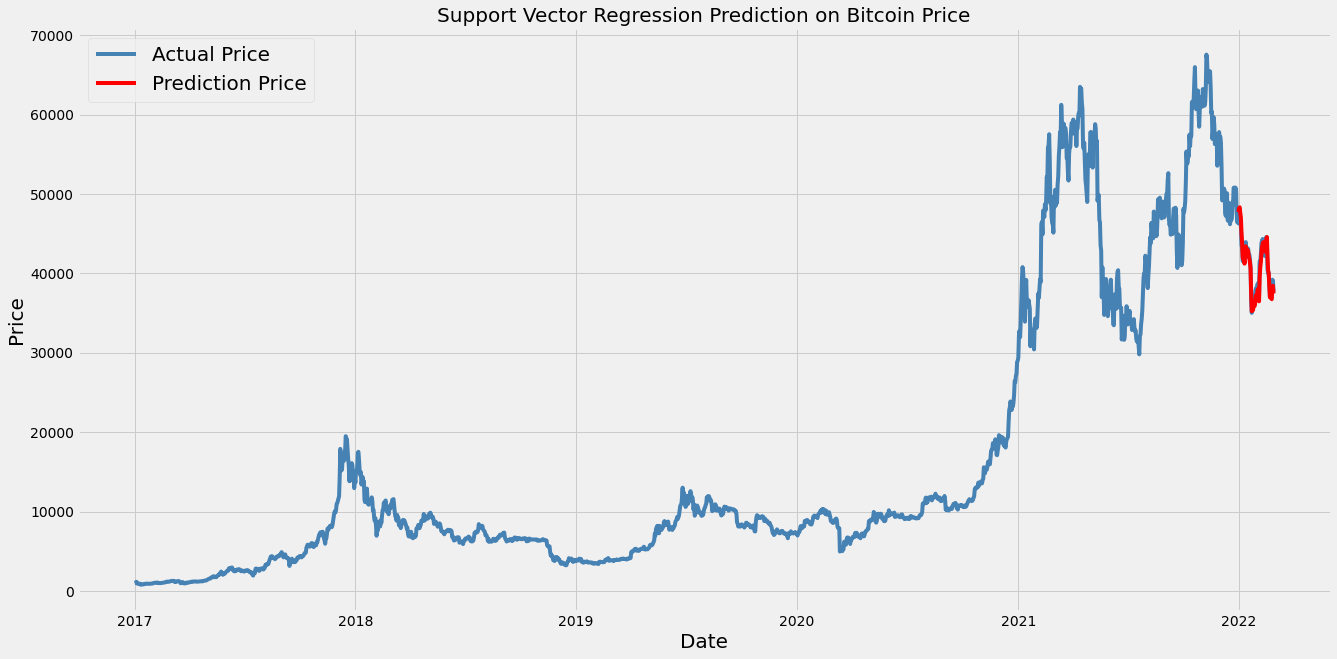

In [53]:
SVR_train = df[:num_training_days]
SVR_test = df[num_training_days:]

SVR_test['Predictions'] = 0
SVR_test['Predictions'] = y_pred_svr

SVR_test.index = df[num_training_days:].index
# lr_train.index = df[:num_training_days].index

# Plotting of graph 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label = 'Actual Price')
ax.plot(SVR_test['Date'],SVR_test['Predictions'], color = 'r', label = 'Prediction Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Support Vector Regression Prediction on Bitcoin Price', fontsize = 20)
ax.legend(prop={'size': 20})


# Random forest regression

In [54]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()
regr.fit(X_train, y_train)
y_pred_regr = regr.predict(X_test)


In [55]:
regr_rmse = math.sqrt(mean_squared_error(y_test, y_pred_regr))
regr_rmse

970.8696202564367

In [56]:
regr_mae = mean_absolute_error(y_test, y_pred_regr)
regr_mae

794.5305786546613

In [57]:
regr_mape = mean_absolute_percentage_error(y_test, y_pred_regr)
regr_mape

0.019718973841265676

C:\Users\user\AppData\Local\Temp/ipykernel_6556/476041901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regr_test['Predictions'] = 0
C:\Users\user\AppData\Local\Temp/ipykernel_6556/476041901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regr_test['Predictions'] = y_pred_regr


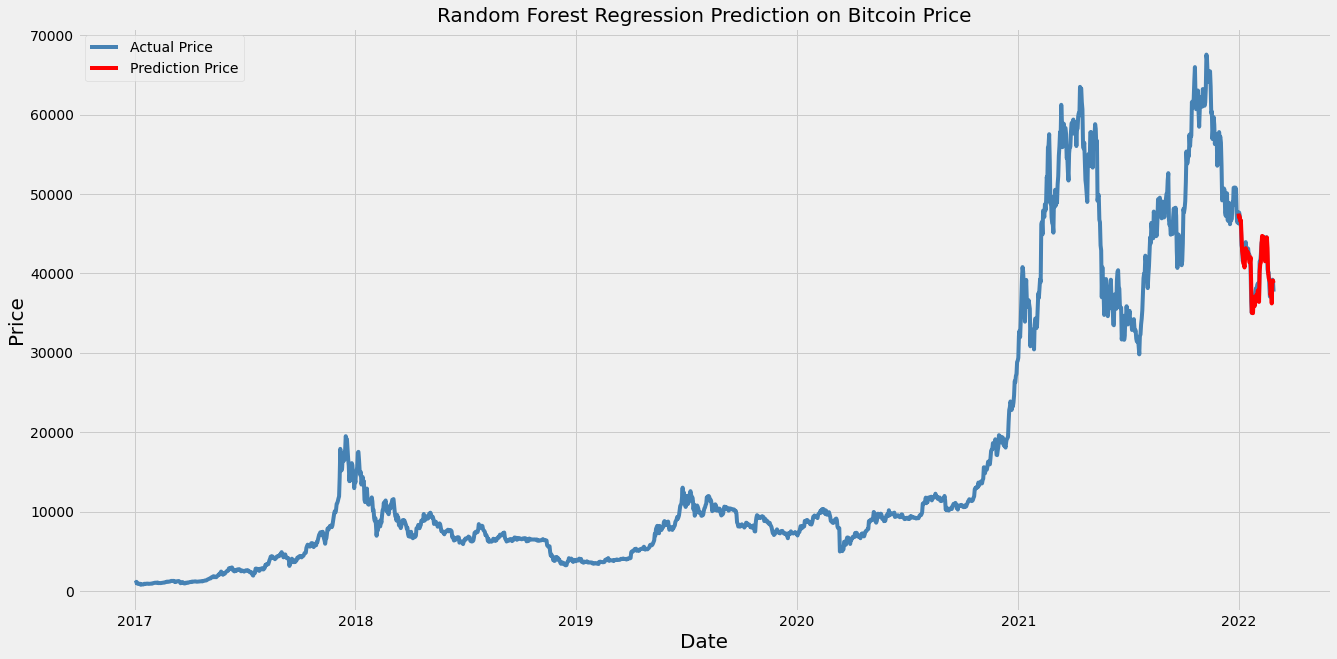

In [59]:
regr_train = df[:num_training_days]
regr_test = df[num_training_days:]

regr_test['Predictions'] = 0
regr_test['Predictions'] = y_pred_regr

regr_test.index = df[num_training_days:].index
# lr_train.index = df[:num_training_days].index

# Plotting of graph 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label = 'Actual Price')
ax.plot(regr_test['Date'],regr_test['Predictions'], color = 'r', label = 'Prediction Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Random Forest Regression Prediction on Bitcoin Price', fontsize = 20)
ax.legend()

# LSTM

In [60]:
# Training timeframe
training_days = pd.date_range(start="2017-01-01",end="2021-12-31")
num_training_days = len(training_days)


#create a new data set to predict the future value 
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close', 'Open','High','Low','Volume','MA_50','MA_200','SMA_50','SMA_200',
                                                        'EMA_50','EMA_100','macd','macdsignal','macdhist','rsi_14','BB_Upper','BB_middle','BB_lower'])
for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Close'][i] = df['Close'][i]
    new_data['Open'][i] = df['Open'][i]
    new_data['High'][i] = df['High'][i]
    new_data['Low'][i] = df['Low'][i]
    new_data['Volume'][i] = df['Volume'][i]
    new_data['MA_50'][i] = df['MA_50'][i]
    new_data['MA_200'][i] = df['MA_200'][i]
    new_data['SMA_50'][i] = df['SMA_50'][i]
    new_data['SMA_200'][i] = df['SMA_200'][i]
    new_data['EMA_50'][i] = df['EMA_50'][i]
    new_data['EMA_100'][i] = df['EMA_100'][i]
    new_data['macd'][i] = df['macd'][i]
    new_data['macdsignal'][i] = df['macdsignal'][i]
    new_data['macdhist'][i] = df['macdhist'][i]
#     new_data['rsi_5'][i] = df['rsi_5'][i]
    new_data['rsi_14'][i] = df['rsi_14'][i]
    new_data['BB_Upper'][i] = df['BB_Upper'][i]
    new_data['BB_middle'][i] = df['BB_middle'][i]
    new_data['BB_lower'][i] = df['BB_lower'][i]
    
    
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
#df.drop('Date', axis=1, inplace=True)
training_df = new_data.values.astype(float)


train = training_df[0:num_training_days,:]
test = training_df[num_training_days:,:]



In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(training_df)

# prediction days is 60, i'm using 60 days of data to predict the next day 
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0:train.shape[1]])
    y_train.append(scaled_data[i:i+1,0])
x_train, y_train = np.array(x_train), np.array(y_train)




In [62]:
x_train.shape

(1766, 60, 18)

In [63]:
y_train.shape

(1766, 1)

In [64]:
new_data

,Close,Open,High,Low,Volume,MA_50,MA_200,SMA_50,SMA_200,EMA_50,EMA_100,macd,macdsignal,macdhist,rsi_14,BB_Upper,BB_middle,BB_lower
0,998.325012,963.65802,1003.080017,958.698975,147775008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1021.75,998.617004,1031.390015,996.702026,222184992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1043.839966,1021.599976,1044.079956,1021.599976,185168000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1154.72998,1044.400024,1159.420044,1044.400024,344945984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1013.380005,1156.72998,1191.099976,910.416992,510199008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,37296.570312,38285.28125,39122.394531,37201.816406,21849073843,40619.632969,49346.491367,40619.632969,49346.491367,41873.91086,44666.004424,-772.392026,-178.537677,-593.85435,37.529047,46152.580286,41548.570898,36944.561511
1880,38332.609375,37278.566406,38968.839844,34459.21875,46383802093,40514.905078,49319.163828,40514.905078,49319.163828,41735.036292,44540.59066,-828.791941,-308.588529,-520.203411,42.098947,46203.114098,41390.157617,36577.201136
1881,39214.21875,38333.746094,39630.324219,38111.34375,26545599159,40435.970859,49283.40791,40435.970859,49283.40791,41636.180702,44435.117949,-793.207172,-405.512258,-387.694914,45.736592,46184.050294,41278.810352,36373.570409
1882,39105.148438,39213.082031,40005.347656,38702.535156,17467554129,40386.915781,49251.008496,40386.915781,49251.008496,41536.924535,44329.573999,-764.988735,-477.407553,-287.581182,45.356934,46077.309351,41113.446094,36149.582836


In [65]:
inputs = new_data[len(new_data) - len(test) - 60:].values

inputs  = scaler.fit_transform(inputs)

In [66]:
x_test, y_test = [],[]
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i,0:inputs.shape[1]])
    y_test.append(inputs[i:i+1,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)



In [67]:
x_test.shape

(58, 60, 18)

In [68]:
y_test.shape

(58, 1)

In [69]:
model = Sequential()

model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 18)))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [70]:
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=32,verbose=0)

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           47600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________


In [72]:
x_test.shape

(58, 60, 18)

In [73]:
y_pred_lstm = model.predict(x_test)
y_pred_lstm = np.array(y_pred_lstm)
#model.evaluate(x_test, y_test)
# lstm rmse and other evaluation matrix 

In [74]:
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred_lstm))
lstm_rmse

0.07987176953226133

In [76]:
lstm_mae = mean_absolute_error(y_test, y_pred_lstm)
lstm_mae

0.06302055692983134

In [77]:
lstm_mape = mean_absolute_percentage_error(y_test, y_pred_lstm)
lstm_mape

15983814513064.215

In [78]:
#Predictions_price return me 1 array of data. i need to convert into 5 array of data before i can 
y_pred_lstm_copies = np.repeat(y_pred_lstm, training_df.shape[1], axis=-1)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_copies)[:,0]


C:\Users\user\AppData\Local\Temp/ipykernel_6556/439000522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_test['Predictions'] = 0
C:\Users\user\AppData\Local\Temp/ipykernel_6556/439000522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_test['Predictions'] = y_pred_lstm


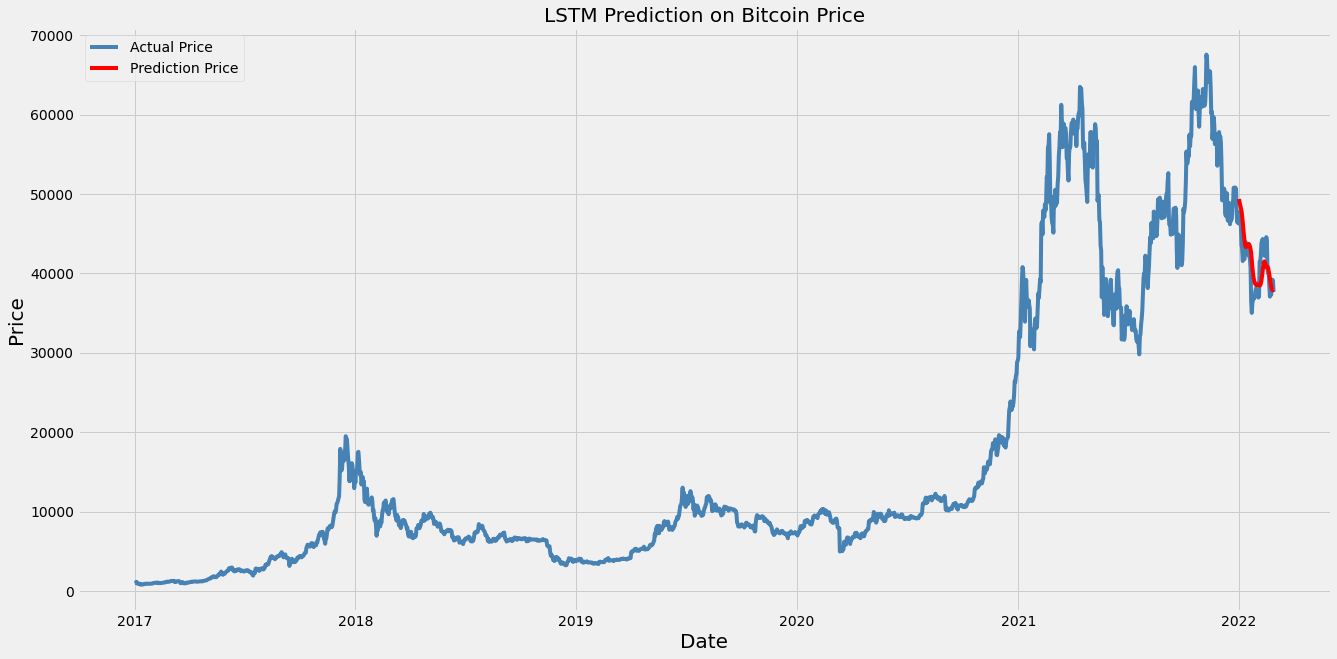

In [79]:
lstm_train = df[:num_training_days]
lstm_test = df[num_training_days:]

lstm_test['Predictions'] = 0
lstm_test['Predictions'] = y_pred_lstm

lstm_test.index = df[num_training_days:].index
# lr_train.index = df[:num_training_days].index

# Plotting of graph 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label = 'Actual Price')
ax.plot(lstm_test['Date'],lstm_test['Predictions'], color = 'r', label = 'Prediction Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('LSTM Prediction on Bitcoin Price', fontsize = 20)
ax.legend()

# Predicting future value 

In [81]:
#Predict the next 30 days of bitcoin price
train_dates = pd.to_datetime(df['Date'])
n_future=30
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [82]:
y_pred_forecast = model.predict(x_test[-n_future:])

In [83]:
y_pred_forecast_copies = np.repeat(y_pred_forecast, training_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(y_pred_forecast_copies)[:,0]

In [84]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [85]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

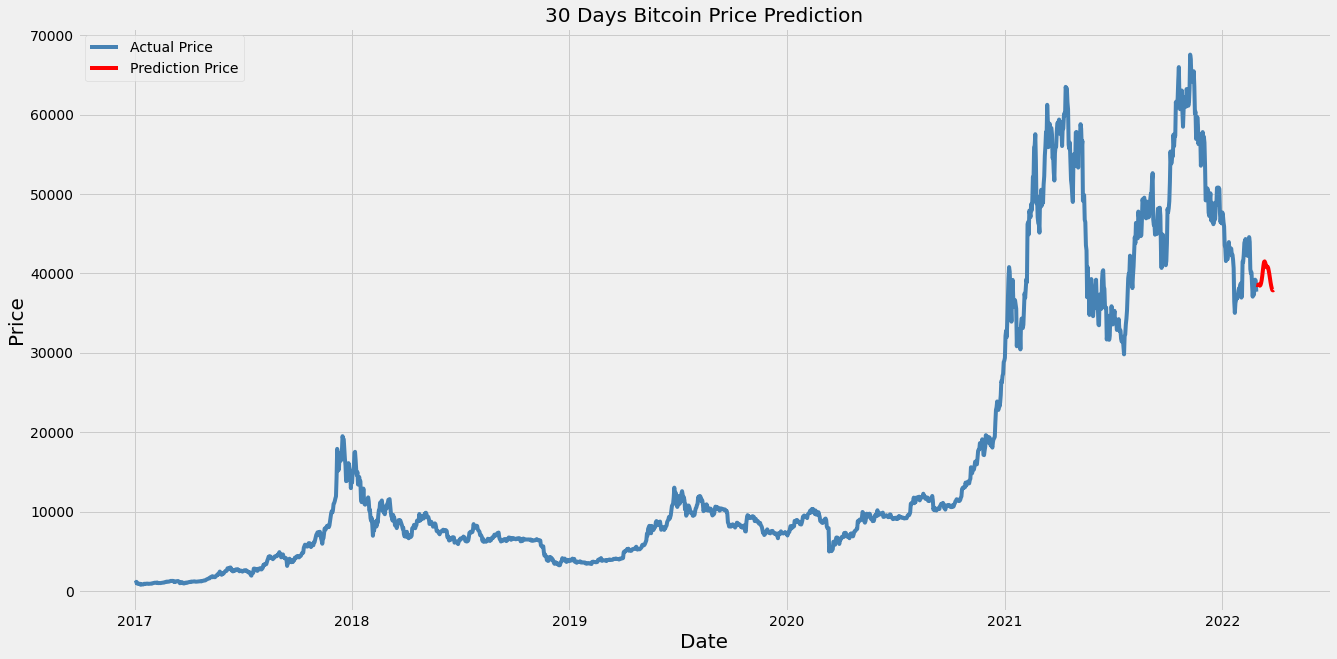

In [86]:

# Plotting of graph 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['Date'],df['Close'], color='steelblue', label = 'Actual Price')
ax.plot(df_forecast['Date'],df_forecast['Close'], color = 'r', label = 'Prediction Price')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('30 Days Bitcoin Price Prediction', fontsize = 20)
ax.legend()

In [83]:
predict_rmse = math.sqrt(mean_squared_error(y_test[-n_future:], y_pred_future))
predict_rmse

39229.89889751468

In [84]:
predict_mae = mean_absolute_error(y_test[-n_future:], y_pred_future)
predict_mae

39219.077581395635

In [85]:
predict_mape = mean_absolute_percentage_error(y_test[-n_future:], y_pred_future)
predict_mape

302603.3592824733

# Algorithmic Trading with MACD Signal 

In [87]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [88]:
df_macd = get_macd(df['Close'], 26, 12, 9)
df_macd


,macd,signal,hist
0,0.000000,0.000000,0.000000
1,1.868660,0.373732,1.494928
2,5.073577,1.313701,3.759876
3,16.372661,4.325493,12.047168
4,13.762854,6.212965,7.549889
...,...,...,...
1879,-772.392026,-178.537677,-593.854350
1880,-828.791941,-308.588529,-520.203411
1881,-793.207172,-405.512258,-387.694914
1882,-764.988735,-477.407553,-287.581182


In [89]:
# Trading Signal, 
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df['Close'], df_macd)

In [89]:
df_macd['macd'].shape

(1884,)

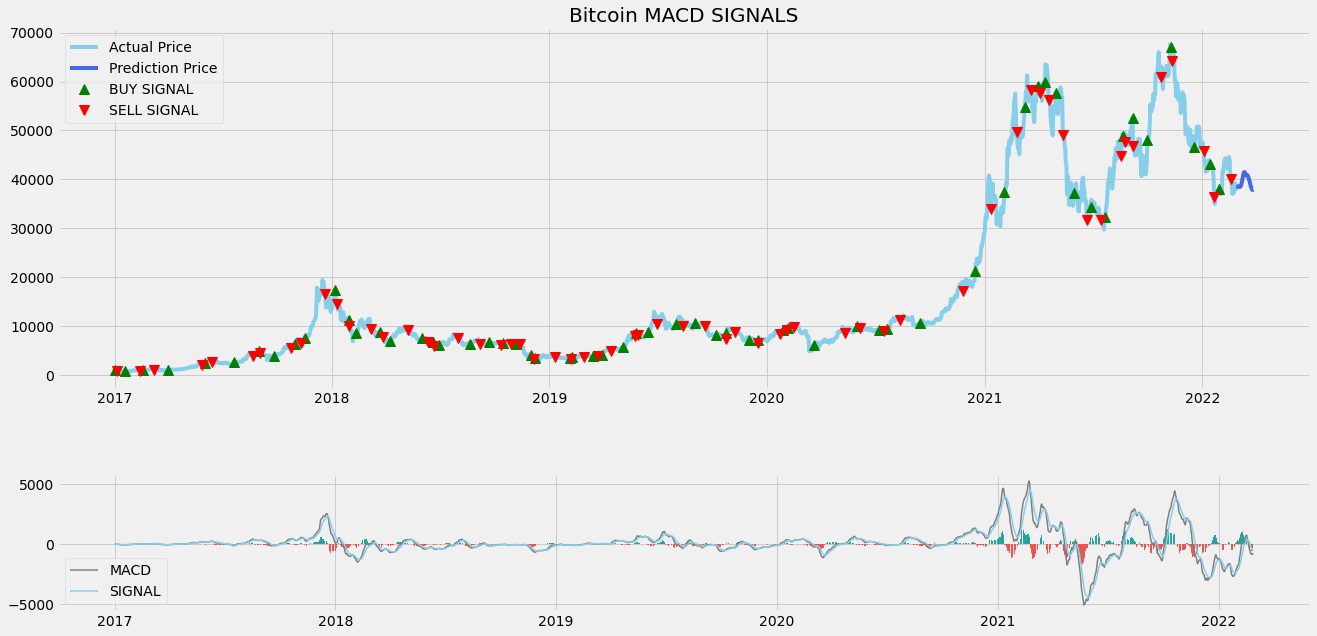

In [90]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (6,0), rowspan = 3, colspan = 1)

ax1.plot(df['Date'],df['Close'], color='skyblue', label = 'Actual Price')
ax1.plot(df_forecast['Date'],df_forecast['Close'], color = 'royalblue', label = 'Prediction Price')
ax1.plot(df['Date'], buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df['Date'], sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('Bitcoin MACD SIGNALS')
ax2.plot(df['Date'],df_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(df['Date'],df_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(df_macd)):
    if str(df_macd['hist'][i])[0] == '-':
        ax2.bar(df['Date'][i], df_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(df['Date'][i], df_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower left')
plt.show()

In [91]:
# Holding bitcoin is 1, 0 is not holding any bitcoin
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = df_macd['macd']
signal = df_macd['signal']
Close_price = df['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(df.index)

In [93]:
frames = [Close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy

,Close,macd,signal,macd_signal,macd_position
0,998.325012,0.000000,0.000000,0,1
1,1021.750000,1.868660,0.373732,1,1
2,1043.839966,5.073577,1.313701,0,1
3,1154.729980,16.372661,4.325493,0,1
4,1013.380005,13.762854,6.212965,0,1
...,...,...,...,...,...
1879,37296.570312,-772.392026,-178.537677,0,0
1880,38332.609375,-828.791941,-308.588529,0,0
1881,39214.218750,-793.207172,-405.512258,0,0
1882,39105.148438,-764.988735,-477.407553,0,0


In [94]:
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(df_ret)):
    try:
        returns = df_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

In [98]:
investment_value = 10000
number_of_stocks = floor(investment_value/df['Close'][0])
macd_investment_ret = []

In [99]:
for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

In [103]:
macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print('Profit gained from the MACD strategy by investing $10k in Bitcoin : {}'.format(total_investment_ret))
print('Profit percentage of the MACD strategy : {}%'.format(profit_percentage))

Profit gained from the MACD strategy by investing $10k in Bitcoin : 393210.57
Profit percentage of the MACD strategy : 3932%
